In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from googlesearch import search
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
import sys
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import math

Using TensorFlow backend.


In [2]:
stock_name=input('Enter the name of the company/stock :')

Enter the name of the company/stock :tesla


In [3]:
searches=stock_name+' stock yahoo'
searches

'tesla stock yahoo'

In [4]:
results = []
for i in search(searches,     # The query you want to run
                tld = 'com',  # The top level domain
                lang = 'en',  # The language
                num = 10,     # Number of results per page
                start = 0,    # First result to retrieve
                stop = 10,    # Last result to retrieve
                pause = 2.0,  # Lapse between HTTP requests
               ):
    results.append(i)
    print(i)

https://finance.yahoo.com/quote/TSLA/
https://in.finance.yahoo.com/q?s=TSLA
https://www.cnbc.com/quotes/?symbol=TSLA
https://www.youtube.com/watch?v=gSsfkzNlMY4
https://www.youtube.com/watch?v=5ACe0s0wcUk
https://wallmine.com/nasdaq/tsla
https://finbox.com/NASDAQGS:TSLA
https://www.nasdaq.com/market-activity/stocks/tsla
https://www.pinterest.com/pin/195906652528229349/
https://www.fool.com/investing/2020/08/21/tesla-stock-closes-in-on-2100-heres-why-its-rising/


In [5]:
string=results[0]
words=string.split('/')
name=words[-2]
name

'TSLA'

In [6]:
my_share = share.Share(name)
database = None

try:
    database = my_share.get_historical( share.PERIOD_TYPE_YEAR,3
                                          ,share.FREQUENCY_TYPE_DAY,1)
except YahooFinanceError as e:
    print(e.message)
    sys.exit(1)

In [7]:
data=pd.DataFrame(database)

In [8]:
data.head()

,timestamp,open,high,low,close,volume
0,1506691800000,68.372002,68.935997,67.720001,68.220001,25535500
1,1506951000000,68.503998,68.739998,67.101997,68.306000,26434000
2,1507037400000,67.180000,69.709999,66.255997,69.627998,50768000
3,1507123800000,70.250000,71.723999,69.919998,71.001999,40817500
4,1507210200000,71.199997,71.487999,70.269997,71.066002,20858500


In [9]:
high=np.array(data['high'])
low=np.array(data['low'])
price=(high+low)/2

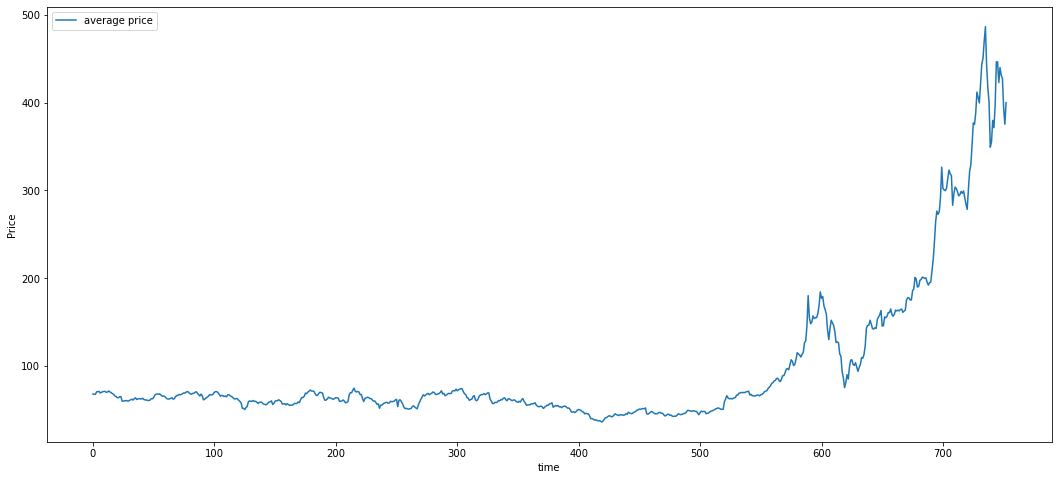

In [10]:
plt.figure(figsize=(18,8))
plt.plot(price)
plt.xlabel('time')
plt.ylabel('Price')
plt.legend(['average price'])
plt.show()

In [11]:
train_perc=math.floor(data['high'].count()*0.9)
train_perc

677

In [12]:
train_data=price[0:train_perc]
test_data=price[train_perc:]

In [13]:
sc=MinMaxScaler(feature_range=(0,1))
train_data=train_data.reshape(-1,1)
test_data=test_data.reshape(-1,1)
train_data=sc.fit_transform(train_data)
test_data=sc.fit_transform(test_data)

In [14]:
def create_dataset(data,look_back,shuffle=False):
    gen=TimeseriesGenerator(data,data,length=look_back,shuffle=False)
    X=[]
    Y=[]
    for i in range(len(gen)):
        a,b=gen[i]
        for j in range(a.shape[0]):
            X.append(a[j])
            Y.append(b[j])
    
    return np.array(X),np.array(Y)

In [15]:
X_train,Y_train=create_dataset(train_data,look_back=7)
X_test,Y_test=create_dataset(test_data,look_back=7)

In [16]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(670, 7, 1) (670, 1)
(69, 7, 1) (69, 1)


In [17]:
look_back=7       #look at last 7 days prices for prediction
num_forecasts=5   #forecast for the next 5 days

In [18]:
X_train=X_train.reshape(-1,look_back)
X_test=X_test.reshape(-1,look_back)
Y_train=Y_train.reshape(-1,1)
Y_test=Y_test.reshape(-1,1)

In [19]:
xgmodel = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.05,max_depth=15,n_estimators=200,verbose=False)

In [20]:
xgmodel.fit(X_train,Y_train)

[10:59:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=False,
             verbosity=None)

In [21]:
y_pred=xgmodel.predict(X_test)

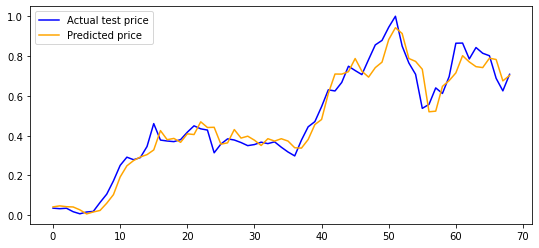

In [22]:
plt.figure(figsize=(9,4))
plt.plot(Y_test,label='Actual test price',color='blue')
plt.plot(y_pred,label='Predicted price',color='orange')
plt.legend()
plt.show()

In [23]:
def future_predict(data,model,look_back,num_forecasts):
    output=[]
    for i in range(num_forecasts):
        data=data[-look_back:]
        pred=model.predict(data.reshape(1,look_back))
        output.append(pred)
        data=np.concatenate([data,np.array(pred).reshape(-1,1)],axis=0)
    return output

In [24]:
average=sc.fit_transform(price.reshape(-1,1))

In [25]:
predictions=future_predict(average[-50:],xgmodel,look_back,num_forecasts)

In [26]:
u=average[-100:]
v=np.concatenate([u,np.array(predictions)])

In [27]:
past_values=sc.inverse_transform(u)
future_values=sc.inverse_transform(v)

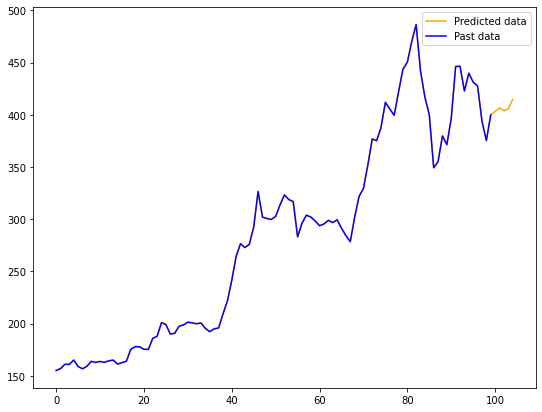

In [28]:
plt.figure(figsize=(9,7))
plt.plot(future_values,color='orange',label='Predicted data')
plt.plot(past_values,color='blue',label='Past data')
plt.legend()
plt.show()